### XGBoost
- In this file, XGBoost model's sampling ratio of columns(colsample_bytree) is tuned by grid search using bootstrap samples. Log-loss is the objective function and fitting stops when the log-loss doesn't decrease for 20 iterations in a row. The other hyperparameters are fixed as well. 
- An optimal cut-off probability is found using precision-recall curve and F_{1.5} score and the final model is fit with the training set(not the training set and validation set combined due to the way calibrator fit works and and the xgboost model was trained using validation set for evaluation metric). 
- The final predictions are calibrated using Platt Scaling(sigmoid) and the cut-off probability is tuned based on F score. The results are shown by confusion matrix, feature importance, and permutation feature importance.

#### Compare two XGBoost models: <br>
1) column sampling rate as 0.2 which was chosen by bootstrap grid-search<br>
2) column sampling rate as 0.05 which is the squared root of the number of features

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
from ipynb.fs.full.helper_functions import * # Custom function to create dummy variables
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve

import eli5
from eli5.sklearn import PermutationImportance

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

**Import the datasets**

In [2]:
X_train, X_val, y_train, y_val = pd.read_pickle('data/imp_train.pkl'), pd.read_pickle('data/imp_val.pkl'), pd.read_pickle('data/y_train.pkl'), pd.read_pickle('data/y_val.pkl')

In [3]:
eval_set = [(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go

#### Bootstrap grid-search for colsample_bytree of 0.1, 0.2, ... 1.0


1) Create 10 bootstrap samples of size 1/10 from the original traning set<br>
2) Run the following steps:<br>
&emsp; 1) Select a bootstrap sample<br>
&emsp; 2) Compute F scores across different colsample rates<br>
&emsp; 3) Select the best colsample rate by F score<br>
3) Choose the majority of the colsample rate

In [4]:
colsample_rates = np.linspace(0.1, 1, 10)
num_bootstrap_samples = 10

In [5]:
df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis = 1)
bootstrap_samples = []
for i in range(num_bootstrap_samples):
    bootstrap_samples.append(df.sample(frac = 0.1, replace=True, random_state=i))

In [6]:
max_beta_colrates = []
fbeta_scores = defaultdict(list)

for index, bootstrap_sample in enumerate(bootstrap_samples):
    print(f"Bootstrap sample {index}'s iteration", end='   ')
    for colsample_rate in colsample_rates:
        print(f"Column sample rate {colsample_rate}", end = '   ')
        gbm = xgb.XGBClassifier( 
                           n_estimators=30000, #arbitrary large number
                           max_depth=3,
                           objective="binary:logistic",
                           learning_rate=.1, 
                           subsample=1,
                           min_child_weight=1,
                           colsample_bytree= colsample_rate,
                           random_state = 10,
                           scale_pos_weight = 27)
        
        X_train_boot, y_train_boot = bootstrap_sample.drop('isFraud', axis = 1), bootstrap_sample.loc[:,'isFraud']

        eval_set = [(X_train_boot, y_train_boot), (X_val, y_val)]

        xgb_model_boot = gbm.fit( 
                        X_train_boot, y_train_boot, 
                        eval_set=eval_set,
                        eval_metric='logloss',
                        early_stopping_rounds=20,
                        verbose=False #gives output log as below
                       )
        y_pred = xgb_model_boot.predict(X_val)
        fbeta_scores[index].append(fbeta_score(y_val, y_pred, beta = 1.5))
    max_beta_colrates.append(colsample_rates[np.argmax(fbeta_scores[index])])

**0.2** is the majority column sampling rate out of 10 bootstrap samples' votes based on F_{1.5} scores

In [7]:
max(set(max_beta_colrates), key=max_beta_colrates.count)

0.2

#### Model 1. Column sampling rate as 0.2

In [8]:
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.2,
                       random_state = 10,
                       scale_pos_weight = 27
                      )

xgb_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

In [9]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=0, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=27,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [10]:
prec, rec, fbeta, _ = precision_recall_fscore_support(y_train, xgb_model.predict(X_train), beta = 1.5, average = 'binary')
print(f"Train set: Precision = {prec:8.5f}, Recall = {rec:8.5f}, F_1.5 = {fbeta:8.5f}")
prec, rec, fbeta, _ = precision_recall_fscore_support(y_val, xgb_model.predict(X_val), beta = 1.5, average = 'binary')
print(f"Val set: Precision = {prec:8.5f}, Recall = {rec:8.5f}, F_1.5 = {fbeta:8.5f}\n")

Train set: Precision =  0.69479, Recall =  0.98172, F_1.5 =  0.87104
Val set: Precision =  0.55517, Recall =  0.76476, F_1.5 =  0.68517



In [11]:
y_probs = xgb_model.predict_proba(X_val)[:, 1]

Best Fbeta(1.5) score  0.72347 at prob decision threshold >=  0.67883


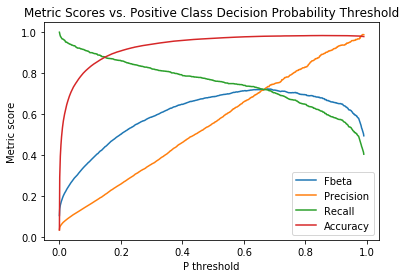

In [12]:
# Fit to the validation set
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(y_probs, y_val)

In [13]:
print(f"Log loss for the second model: {xgb_model.evals_result_['validation_1']['logloss'][-1]}")

Log loss for the second model: 0.100774


#### Model 2. Column sampling rate as 0.05(sqrt of number of features)

In [14]:
round(np.sqrt(X_train.shape[1]) / X_train.shape[1],2)

0.05

In [15]:
gbm2 = xgb.XGBClassifier( 
                       n_estimators=50000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight = 1,
                       colsample_bytree = .05,
                       random_state = 10,
                       scale_pos_weight = 27
                      )

xgb_model2 = gbm2.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='logloss',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

In [16]:
xgb_model2.best_iteration

28925

In [17]:
y_probs2 = xgb_model2.predict_proba(X_val)[:, 1]

Best Fbeta(1.5) score  0.68604 at prob decision threshold >=  0.74324


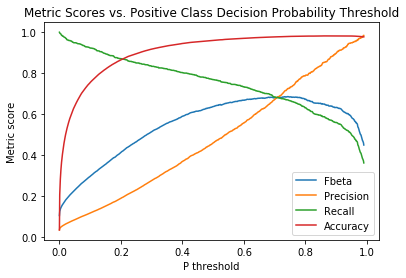

In [18]:
# Fit to the validation set
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(y_probs2, y_val)

In [19]:
print(f"Log loss for the second model: {xgb_model2.evals_result_['validation_1']['logloss'][-1]}")

Log loss for the second model: 0.131042


With column sampling rate as 0.2(4 * sqrt(number of features)), F score seems to be higher.<br>

### Final Model

In [20]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30000, n_jobs=0, num_parallel_tree=1,
              random_state=10, reg_alpha=0, reg_lambda=1, scale_pos_weight=27,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

**Evaluations for training set to check overfitting**<br>
For the final model, we could take a look at the fitted probabilities(training set) to see how well it's fit to the training set compared to the validation set.<br>
Yes, it's overfit. F-score for training set is 0.93 while it's 0.72 for validation set.

Best Fbeta(1.5) score  0.92854 at prob decision threshold >=  0.74523


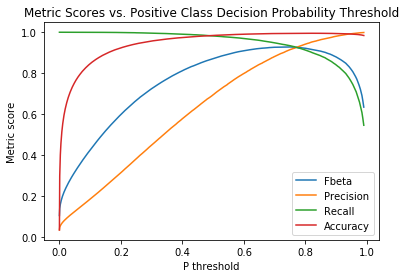

In [21]:
# Fit to the training set
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(xgb_model.predict_proba(X_train)[:, 1], y_train)

Best Fbeta(1.5) score  0.72347 at prob decision threshold >=  0.67883


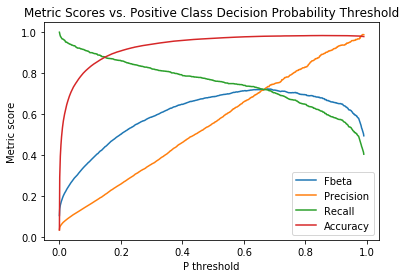

In [22]:
# Fit to the validation set
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(xgb_model.predict_proba(X_val)[:, 1], y_val)

#### *Calibration on the validation set* <br>
The predicted probabilities are likely to be over-forecast in the bins of the predicted probabilities.<br>
url: https://scikit-learn.org/stable/modules/calibration.html

In [23]:
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_val, y_probs, n_bins = 100)

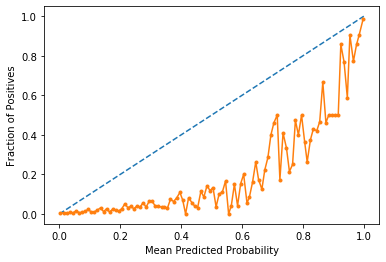

In [24]:
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='.')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives");

Assign the validation set's feature names the feature names that XGBClassifier uses in order to calibrate

In [25]:
new_names = ['f'+str(val) for val in range(X_train.shape[1])]
X_val_calibration = X_val.copy()
X_val_calibration.columns = new_names

*Isotonic regression calibration* <br>
url: https://scikit-learn.org/stable/modules/isotonic.html#isotonic<br>
"*IsotonicRegression produces a series of predictions for the training data which are the closest to the targets  in terms of mean squared error. These predictions are interpolated for predicting to unseen data. The predictions of IsotonicRegression thus form a function that is piecewise linear*"<br><br>

In [26]:
# calibrate model on validation data (Isotonic Regression)
calibrator_isotonic = CalibratedClassifierCV(xgb_model, cv='prefit', method = 'isotonic')
calibrator_isotonic.fit(X_val_calibration, y_val)
# evaluate the model
pred_probs_isotonic = calibrator_isotonic.predict_proba(X_val_calibration)[:, 1]
prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_val, pred_probs_isotonic, n_bins = 100)

# calibrate model on validation data (Platt Scaling)
calibrator_sigmoid = CalibratedClassifierCV(xgb_model, cv='prefit', method = 'sigmoid')
calibrator_sigmoid.fit(X_val_calibration, y_val)
# evaluate the model
pred_probs_sigmoid = calibrator_sigmoid.predict_proba(X_val_calibration)[:, 1]
prob_true_sigmoid, prob_pred_sigmoid = calibration_curve(y_val, pred_probs_sigmoid, n_bins = 100)

**Isotonic Regression vs. Platt Scaling**<br>
Isotonic Regression does a better job although the calibrated probabilities are highly discrete. The small number of unique values(39) after isotonic calibration indicates **highly discretized** predicted probabilities fit to the true proportions(29424 unique values). Platt scaling produced 26014 unique values, but it is not that as well-calibrated.

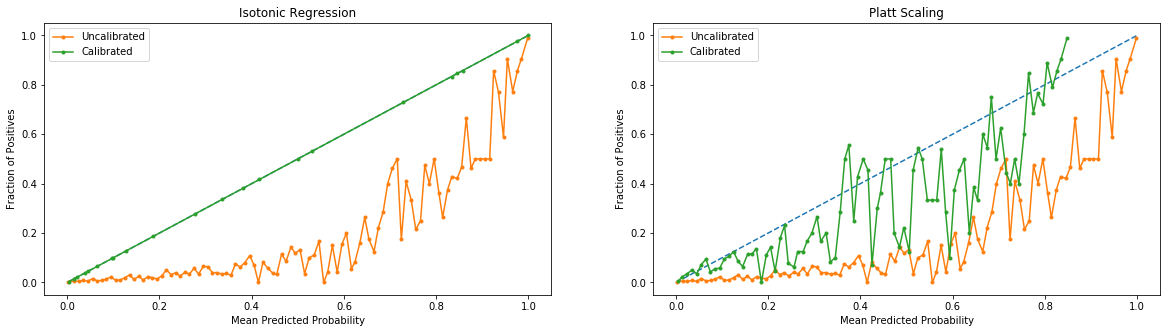

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
prob_true, prob_pred = prob_true_isotonic, prob_pred_isotonic
for i in range(2):
    if i == 1: prob_true, prob_pred = prob_true_sigmoid, prob_pred_sigmoid
    ax[i].plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    ax[i].plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='.', label = 'Uncalibrated')
    ax[i].plot(prob_pred, prob_true, marker='.', label = 'Calibrated')
    ax[i].set_xlabel("Mean Predicted Probability")
    ax[i].set_ylabel("Fraction of Positives")
    ax[i].legend()
ax[0].set_title('Isotonic Regression')
ax[1].set_title('Platt Scaling');

In [28]:
print(f"Original XGB model has {len(np.unique(y_probs))} unique values. \n\
Platt scaling(sigmoid) has {len(np.unique(pred_probs_sigmoid))} unique values. \n\
Isotonic regression scaling has {len(np.unique(pred_probs_isotonic))} unique values.")

Original XGB model has 29424 unique values. 
Platt scaling(sigmoid) has 26014 unique values. 
Isotonic regression scaling has 39 unique values.


**New threshold(cutoff probability) by using Isotonic Regression calibration** <br>

Best Fbeta(1.5) score  0.72347 at prob decision threshold >=  0.18730


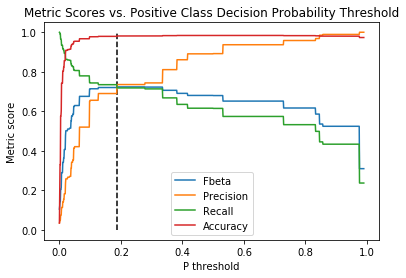

In [29]:
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(pred_probs_isotonic, y_val)
plt.vlines(np.linspace(.0,.99,1000)[np.argmax(fbetas)], ymin = 0, ymax = 1, linestyle = '--', color = 'k');

In [30]:
threshold = 0.18730
y_preds = (pred_probs_isotonic >= threshold).astype(int)
prec, rec, fbeta, _ = precision_recall_fscore_support(y_val, y_preds, beta = 1.5, average = 'binary')
print(f"Val set: Precision = {round(prec, 5)}, Recall = {round(rec, 5)}, F_1.5 = {round(fbeta, 5)}\n")

Val set: Precision = 0.73538, Recall = 0.7183, F_1.5 = 0.72347



New threshold(cutoff probability) by using Platt Scaling(sigmoid) calibration <br>

/Users/jungakim/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Fbeta(1.5) score  0.72347 at prob decision threshold >=  0.34982


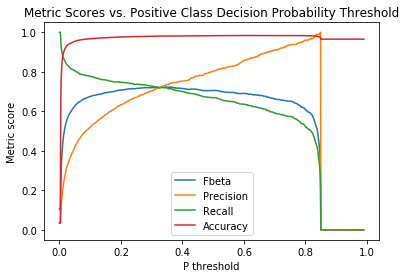

In [31]:
precs, recs, fbetas, acc_scores = plot_fbeta_recall_precision_acc(pred_probs_sigmoid, y_val)

### Finally, see the model's performance...

Import the test sets

In [32]:
X_test, y_test = pd.read_pickle('data/imp_test.pkl'), pd.read_pickle('data/y_test.pkl')

Assign the test set's feature names the feature names that XGBClassifier uses in order to calibrate

In [33]:
new_names = ['f'+str(value) for value in range(X_test.shape[1])]
X_test_calibration = X_test.copy()
X_test_calibration.columns = new_names

**Calibrate the predicted test set's probabilities with Isotonic Regression**

In [34]:
y_probs_test = xgb_model.predict_proba(X_test_calibration)[:, 1]
prob_true_uncalibrated_test, prob_pred_uncalibrated_test = calibration_curve(y_test, y_probs_test, n_bins = 100)
# Isotonic Regression
pred_probs_isotonic_test = calibrator_isotonic.predict_proba(X_test_calibration)[:, 1]

**The model's precision and recall score**<br>
Precision increased by around 0.1 and recall dropped by around 0.03

In [35]:
threshold = 0.18730 # Threshold decided during validation after calibrated.
y_preds = (pred_probs_isotonic_test >= threshold).astype(int)
prec, rec, fbeta, _ = precision_recall_fscore_support(y_test, y_preds, beta = 1.5, average = 'binary')
print(f"Test set: Precision = {round(prec, 5)}, Recall = {round(rec, 5)}, F_1.5 = {round(fbeta, 5)}\n")

Test set: Precision = 0.75479, Recall = 0.7241, F_1.5 = 0.73328



**Confusion Matrix**<br>
- We are going to miss 27.6%(1 - recall) of the fraud...(left, top-right)
- If we predict a transaction as fraud, it is 75.5% likely that it is indeed fraud(right, top-left). In other words, if we investigate a transaction that is predicted as fruad, there's 24.5% chance that the transaction is actually not fraudulent(right, bottom-left).
- If a transaction is predicted as negative, there's only 1.0% chance that it was actually a fraud(right, top-right).
- Out of all the legal transactions, only 0.9%(1 - specificity) of them will be misclassifed as fraud(left, bottom-left).

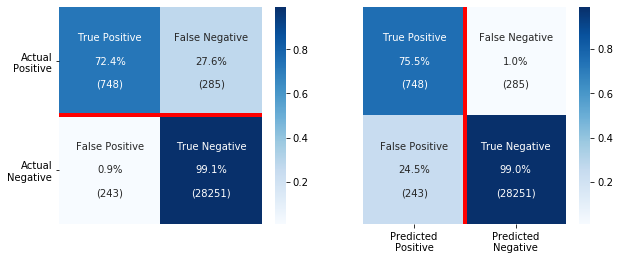

In [36]:
cf_matrix = confusion_matrix(y_test, y_preds)
reord_cf_matrix = np.array([[cf_matrix[1, 1], cf_matrix[1, 0]], [cf_matrix[0, 1], cf_matrix[0, 0]]])# Re-ordered confusion matrix

fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=False)
neg_total, pos_total, neg_pred_total, pos_pred_total = sum(y_test == 0), sum(y_test == 1), sum(y_preds == 0), sum(y_preds == 1)
group_names = ["True Positive\n", "False Negative\n", "False Positive\n", "True Negative\n"]
cf_mat_prop_truth = reord_cf_matrix / np.array([[pos_total, pos_total], [neg_total, neg_total]])
cf_mat_prop_pred = reord_cf_matrix / np.array([[pos_pred_total, neg_pred_total], [pos_pred_total, neg_pred_total]])
group_percentages_truth = [f"{perc:.1f}%\n\n({num})" for perc, num in zip(cf_mat_prop_truth.flatten()*1e2, reord_cf_matrix.flatten())]
group_percentages_pred = [f"{perc:.1f}%\n\n({num})" for perc, num in zip(cf_mat_prop_pred.flatten()*1e2, reord_cf_matrix.flatten())]

labels_truth = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages_truth)]
labels_truth = np.asarray(labels_truth).reshape(2,2)
s = sns.heatmap(cf_mat_prop_truth, annot=labels_truth, fmt='', cmap='Blues', ax = ax[0], yticklabels = ['Actual\nPositive', 'Actual\nNegative'])
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 10)
ax[0].get_xaxis().set_visible(False)
ax[0].axhline(1, -0.5, 1, color = 'red', linewidth=4)

labels_pred = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_percentages_pred)]
labels_pred = np.asarray(labels_pred).reshape(2,2)
sns.heatmap(cf_mat_prop_pred, annot=labels_pred, fmt='', cmap='Blues', ax = ax[1])
ax[1].set_xticklabels(['Predicted\nPositive', 'Predicted\nNegative'])
ax[1].get_yaxis().set_visible(False)
ax[1].axvline(1, -1, 1, color = 'red', linewidth=4);

**Feature Importance**<br>
The Vesta-engineered features were contributing to the model predictions a lot. This is probably because Vesta-engineered features are highly correlated with fraud and are numeric variables which can be split into many categories that tree can re-use the same variable multiple times.

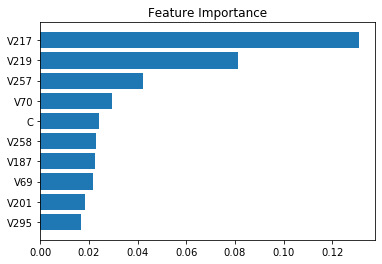

In [37]:
feature_importances_xgb = xgb_model.feature_importances_
index = np.argsort(feature_importances_xgb)
plt.barh(range(10), feature_importances_xgb[index[-10:]])
plt.yticks(range(10), X_train.columns[index[-10:]])
plt.title('Feature Importance');

**Permutation Importance**<br>
Permutation Importance in this setting measures how much reduction in *recall* happened by removing(shuffling randomly) one feature at a time in 5 iterations(using the average reduction in 5 iterations) such that a large reduction in recall would indicate that the feature is important.<br>
This blog explains well how permutation importance works:  https://www.kaggle.com/dansbecker/permutation-importance<br>

- Permutation Importance with scoring method as "recall" on test set makes more sense for this project rather than feature importance of the model, since the model was chosen based on the high recall using F_{1.5} score.
- Counting(C) data such as number of personal info associated with the user, timedelta(D) such as time between transactions, transaction amount, and transaction DT(assuming the date of transaction) seem to be closely related in classification. This may be intuitive features related to fraud like fraudulent transactions may have multiple accounts on one card, or there could be short time periods between each transactions, transaction amount could be abnormally large, and in certain periods of time like spring break could fraud arise more.

In [38]:
perm = PermutationImportance(xgb_model, scoring = 'recall', n_iter = 5, random_state = 1, cv = 'prefit').fit(X_test_calibration, y_test)
perm_df = pd.read_pickle('xgboost/perm_df.pkl')# Read if second time running
# perm_df = eli5.explain_weights_df(perm, feature_names = X_test.columns.tolist(), top=None)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0761 ± 0.0074,C13
0.0500 ± 0.0082,D2
0.0494 ± 0.0066,TransactionAmt
0.0412 ± 0.0113,C14
0.0401 ± 0.0114,D1
0.0376 ± 0.0102,C5
0.0345 ± 0.0093,D10
0.0339 ± 0.0060,TransactionDT
0.0321 ± 0.0075,V307
0.0319 ± 0.0138,D15


**Checking how calibration did on test set**

A data frame created to compute the proportion of positives within each predicted probability, this way we can be assured that the predicted probabilities are actually somewhat meaningful.

In [39]:
pred_probs = pd.concat([pd.DataFrame(pred_probs_isotonic_test, columns = ['pred_prob']).reset_index(drop=True), 
           y_test.reset_index(drop=True)], axis = 1)

pred_probs.insert(0, 'prop', 1)
df = pred_probs.groupby(['pred_prob', 'isFraud']).count().reset_index()
df2 = pred_probs.groupby(['pred_prob']).count().reset_index().iloc[:, :-1]
df = df.merge(df2, how = 'left', on = 'pred_prob')
df.loc[:, 'prop'] = pd.Series((df.iloc[:, [2]].values / df.iloc[:, [3]].values).squeeze())
df.rename(columns = {'prop_x':'count', 'prop_y':'total'}, inplace = True)
df.loc[(df.isFraud == 0) & (df.prop == 1), ['isFraud', 'count', 'prop']] = [1, 0, 0.]
df.insert(1, 'pred_label', (df.pred_prob >= threshold).astype(int))

Most of the calibrated probabilities follow about 45 degree line which is well calibrated.

7 predicted probabilities are less than 0.6 but the proportion of actual positives is 100%(under-forecast).
9 predicted probabilities are greater than or equal to 0.2 but the proportion of actual positives is 0%(over-forecast).
Each of these outliers account for 0.03%, 0.02% of the total observations in the test set.


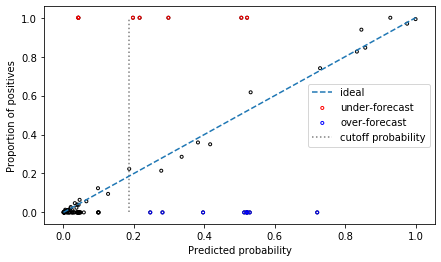

In [40]:
plt.figure(figsize = (7, 4))
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'ideal')

# Proportion as the proportion of actual frauduent transactions
props = df.loc[df.isFraud ==1, :]

plt.scatter(props.loc[:, 'pred_prob'], props.loc[:, 'prop'], facecolor = 'none', edgecolor = 'k', marker = '.')

# outlier
mask_outlier_under, mask_outlier_over = (props.prop == 1.0) & (props.pred_prob <= 0.6), (props.prop == 0.) & (props.pred_prob >= 0.2)
plt.scatter(props.loc[mask_outlier_under, ['pred_prob']], props.loc[mask_outlier_under, ['prop']], facecolor = 'none', edgecolor = 'r', marker = '.', label = 'under-forecast')
plt.scatter(props.loc[mask_outlier_over, ['pred_prob']], props.loc[mask_outlier_over, ['prop']], facecolor = 'none', edgecolor = 'b', marker = '.', label = 'over-forecast')

plt.vlines(threshold, ymin = 0, ymax = 1, linestyle = ':', color = 'gray', label = 'cutoff probability')
plt.xlabel('Predicted probability')
plt.ylabel('Proportion of positives')
plt.legend()

num_outlier_under, num_outlier_over = sum(props.loc[mask_outlier_under, 'total']), sum(props.loc[mask_outlier_over, 'total'])
print(f"{num_outlier_under} predicted probabilities are less than 0.6 but the proportion of actual positives is 100%(under-forecast).")
print(f"{num_outlier_over} predicted probabilities are greater than or equal to 0.2 but the proportion of actual positives is 0%(over-forecast).")
print(f"Each of these outliers account for {100 * num_outlier_under / len(y_test):.2f}%, {100 * num_outlier_over / len(y_test):.2f}% of the total observations in the test set.")

**Spoiler**<br>
Plot the calibrated probabilities vs. uncalibrated probabilities
- *This should not be plot before deciding the threshold or calibration method since we're looking at the actual test set's target values.*
- Seems that Platt Scaling could have done a better calibration for the test set.

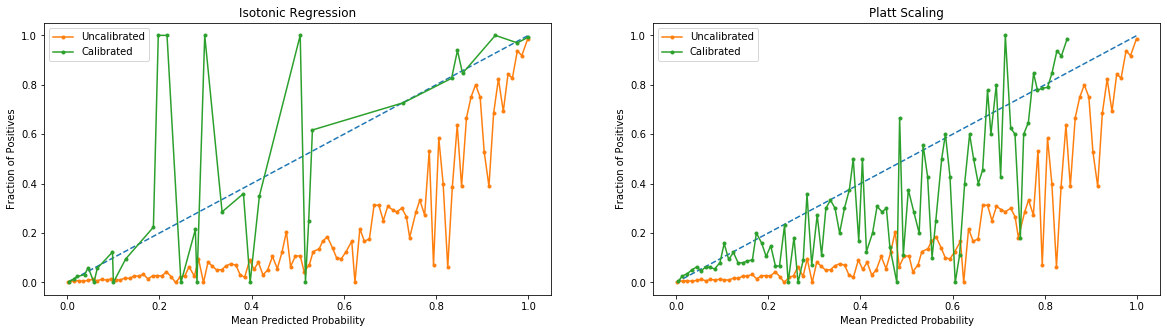

In [41]:
pred_probs_sigmoid_test = calibrator_sigmoid.predict_proba(X_test_calibration)[:, 1]
prob_true_sigmoid_test, prob_pred_sigmoid_test = calibration_curve(y_test, pred_probs_sigmoid_test, n_bins = 100)

prob_true_isotonic_test, prob_pred_isotonic_test = calibration_curve(y_test, pred_probs_isotonic_test, n_bins = 100)
prob_true_test, prob_pred_test = prob_true_isotonic_test, prob_pred_isotonic_test

fig, ax = plt.subplots(1, 2, figsize = (20, 5))
for i in range(2):
    if i == 1: prob_true_test, prob_pred_test = prob_true_sigmoid_test, prob_pred_sigmoid_test
    ax[i].plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    ax[i].plot(prob_pred_uncalibrated_test, prob_true_uncalibrated_test, marker='.', label = 'Uncalibrated')
    ax[i].plot(prob_pred_test, prob_true_test, marker='.', label = 'Calibrated')
    ax[i].set_xlabel("Mean Predicted Probability")
    ax[i].set_ylabel("Fraction of Positives")
    ax[i].legend()
ax[0].set_title('Isotonic Regression')
ax[1].set_title('Platt Scaling');